In [80]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from keras.models import Sequential
from matplotlib import pyplot as plt
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten, TimeDistributed, concatenate
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
import tensorflow as tf
import datetime
from scipy.signal import argrelextrema
from collections import deque
from matplotlib.lines import Line2D
from tensorflow.keras.callbacks import EarlyStopping
import keras
from ti_calculating import *

## Setup Training Data

In [81]:
# Import data for training

train_data = pd.read_csv("/home/deepfintech/Codes/Model/Crypto/ETHUSDT/ETHUSDT_Aug_7_mon.csv")

train_data.head()

,open_time,open,high,low,close,volume,asset_volume,number_of_trades,taker_buy_base,taker_buy_quote
0,2021-08-01 00:00:00,2531.10,2535.01,2531.00,2531.55,1344.93230,3.406791e+06,1586,610.65803,1.546730e+06
1,2021-08-01 00:01:00,2531.57,2532.00,2521.03,2521.15,2157.84445,5.451069e+06,2322,1006.41079,2.541881e+06
2,2021-08-01 00:02:00,2521.69,2525.00,2511.24,2515.17,4053.40892,1.020443e+07,4436,2330.81552,5.868095e+06
3,2021-08-01 00:03:00,2515.17,2526.38,2511.54,2526.35,1825.62825,4.598751e+06,2542,669.83566,1.688183e+06
4,2021-08-01 00:04:00,2526.01,2527.93,2524.00,2527.66,531.04686,1.341283e+06,990,242.78175,6.132041e+05


In [82]:
train_data['open_time'] = pd.to_datetime(train_data['open_time'])

train_data_copy = train_data.copy()

In [83]:
# Get only "open","high","low","close","volume" columns.

columns = ["open","high","low","close","volume"]
train_data = train_data[columns]
train_data.head()

,open,high,low,close,volume
0,2531.10,2535.01,2531.00,2531.55,1344.93230
1,2531.57,2532.00,2521.03,2521.15,2157.84445
2,2521.69,2525.00,2511.24,2515.17,4053.40892
3,2515.17,2526.38,2511.54,2526.35,1825.62825
4,2526.01,2527.93,2524.00,2527.66,531.04686


In [84]:
train_data['open_time'] = train_data_copy['open_time'].apply(lambda x: x.weekday()*24*60+x.hour*60+x.minute)

In [85]:
high_idx = argrelextrema(train_data['high'].values, np.greater, order=2)[0]
low_idx = argrelextrema(train_data['low'].values, np.less, order=2)[0]

close_high_idx = argrelextrema(train_data['close'].values, np.greater, order=2)[0]
close_low_idx = argrelextrema(train_data['close'].values, np.less, order=2)[0]

high_low_idx = np.sort(np.concatenate((close_high_idx, close_low_idx), axis=0), axis=0)

In [86]:
train_data["approx"] = np.nan
train_data["app_highs"] = np.nan
train_data["app_lows"] = np.nan

train_data

,open,high,low,close,volume,open_time,approx,app_highs,app_lows
0,2531.10,2535.01,2531.00,2531.55,1344.93230,8640,NaN,NaN,NaN
1,2531.57,2532.00,2521.03,2521.15,2157.84445,8641,NaN,NaN,NaN
2,2521.69,2525.00,2511.24,2515.17,4053.40892,8642,NaN,NaN,NaN
3,2515.17,2526.38,2511.54,2526.35,1825.62825,8643,NaN,NaN,NaN
4,2526.01,2527.93,2524.00,2527.66,531.04686,8644,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
304886,2918.36,2918.87,2914.80,2918.79,298.05900,1436,NaN,NaN,NaN
304887,2918.78,2921.53,2918.28,2921.53,458.73280,1437,NaN,NaN,NaN
304888,2921.53,2924.70,2920.23,2923.63,326.20110,1438,NaN,NaN,NaN
304889,2923.63,2923.95,2920.95,2920.95,390.63660,1439,NaN,NaN,NaN


In [87]:
train_data["approx"].iloc[high_low_idx] = train_data['close'].iloc[high_low_idx]
train_data["app_highs"].iloc[high_idx] = train_data['high'].iloc[high_idx]
train_data["app_lows"].iloc[low_idx] = train_data['low'].iloc[low_idx]

/home/deepfintech/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [88]:
train_data["approx"] = train_data["approx"].interpolate(method='piecewise_polynomial')
train_data["app_highs"] = train_data["app_highs"].interpolate(method='piecewise_polynomial')
train_data["app_lows"] = train_data["app_lows"].interpolate(method='piecewise_polynomial')

In [89]:
train_data["approx"].iloc[0] = train_data['close'].iloc[0]
train_data["approx"].iloc[-1] = train_data['close'].iloc[-1]

train_data["app_highs"].iloc[0] = train_data['high'].iloc[0]
train_data["app_highs"].iloc[-1] = train_data['high'].iloc[-1]

train_data["app_lows"].iloc[0] = train_data['low'].iloc[0]
train_data["app_lows"].iloc[-1] = train_data['low'].iloc[-1]

In [90]:
train_data["approx"] = train_data["approx"].interpolate(method='piecewise_polynomial')
train_data["app_highs"] = train_data["app_highs"].interpolate(method='piecewise_polynomial')
train_data["app_lows"] = train_data["app_lows"].interpolate(method='piecewise_polynomial')

In [91]:
train_data

,open,high,low,close,volume,open_time,approx,app_highs,app_lows
0,2531.10,2535.01,2531.00,2531.55,1344.93230,8640,2531.550,2535.010000,2531.000
1,2531.57,2532.00,2521.03,2521.15,2157.84445,8641,2523.360,2535.828571,2521.120
2,2521.69,2525.00,2511.24,2515.17,4053.40892,8642,2515.170,2536.647143,2511.240
3,2515.17,2526.38,2511.54,2526.35,1825.62825,8643,2522.900,2537.465714,2512.830
4,2526.01,2527.93,2524.00,2527.66,531.04686,8644,2530.630,2538.284286,2514.420
...,...,...,...,...,...,...,...,...,...
304886,2918.36,2918.87,2914.80,2918.79,298.05900,1436,2920.446,2924.702857,2914.800
304887,2918.78,2921.53,2918.28,2921.53,458.73280,1437,2922.038,2924.701429,2916.235
304888,2921.53,2924.70,2920.23,2923.63,326.20110,1438,2923.630,2924.700000,2917.670
304889,2923.63,2923.95,2920.95,2920.95,390.63660,1439,2920.950,2923.845000,2919.105


<hr style="border:2px solid blue"> </hr>

### **ABCD Pattern for training**

In [92]:
look_order = 50

def getABCD(data):
    max_idx = argrelextrema(data['close'].values, np.greater, order=look_order)[0]
    min_idx = argrelextrema(data['close'].values, np.less, order=look_order)[0]

    min_max_list = np.concatenate((min_idx, max_idx))
    min_max_list.sort()

    new_max_list = []
    temp_max_list = []

    new_min_list = []
    temp_min_list = []

    for count, idx in enumerate(min_max_list):
        if idx in max_idx:
            temp_max_list.append(idx)
            if(len(temp_min_list)>0):
                new_min_list.append(temp_min_list)
                temp_min_list = []
        else:
            temp_min_list.append(idx)
            if(len(temp_max_list)>0):
                new_max_list.append(temp_max_list)
                temp_max_list=[]

    if(len(temp_max_list)>0):
        new_max_list.append(temp_max_list)
    if(len(temp_min_list)>0):
        new_min_list.append(temp_min_list)


    global_max_list = []
    global_min_list = []

    for i in new_max_list:
        global_max_list.append(data.iloc[i]['close'].idxmax())

    for i in new_min_list:
        global_min_list.append(data.iloc[i]['close'].idxmin())

    global_min_max_list = np.concatenate((global_min_list, global_max_list))
    global_min_max_list.sort()
    
    return global_min_list, global_max_list, global_min_max_list

train_global_min_list, train_global_max_list, train_global_min_max_list = getABCD(train_data)


<ipython-input-93-687c820f183e>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(train_data_copy.iloc[train_global_min_max_list].open_time, train_data.iloc[train_global_min_max_list]['close'],color=colors[3], lineStyle='--')


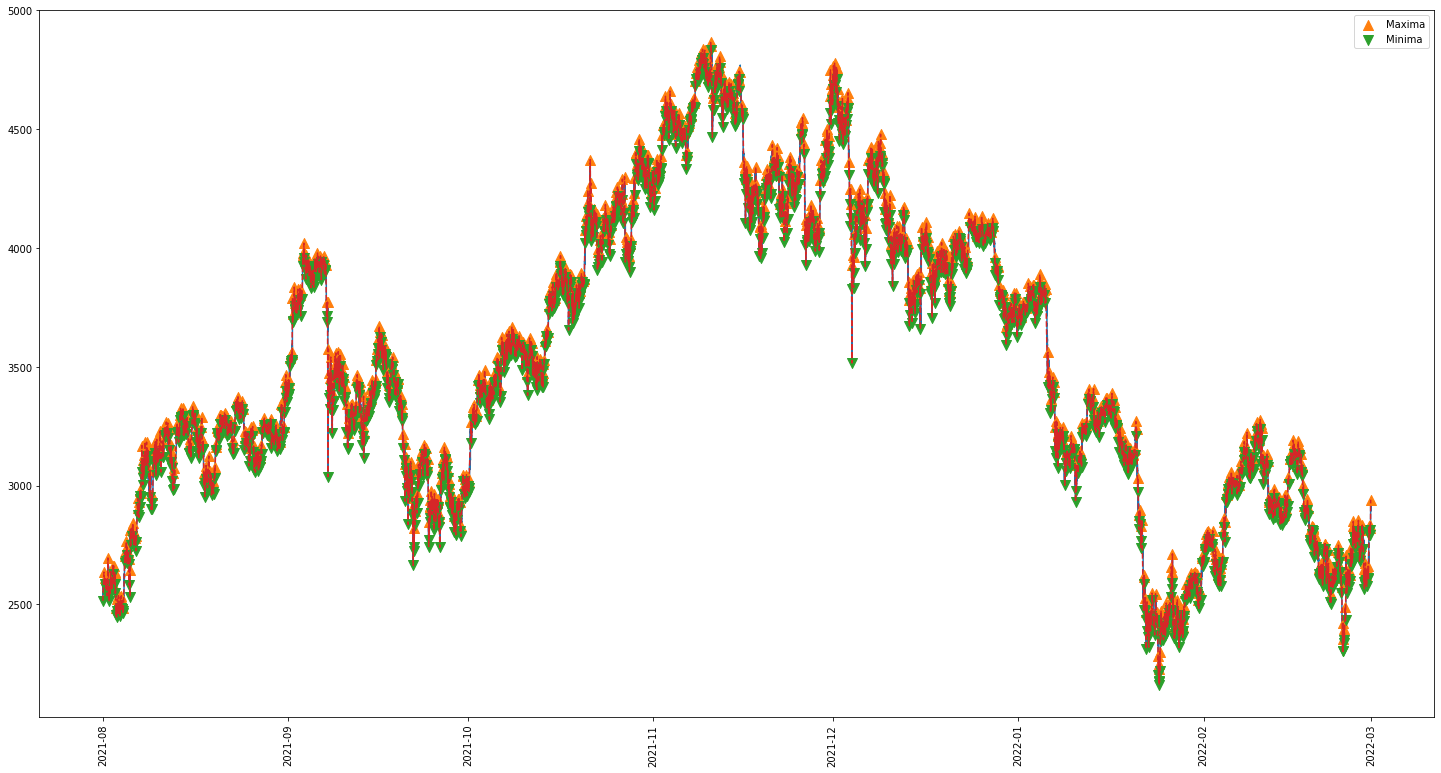

In [93]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


plt.figure(figsize=(25, 13))
plt.plot(train_data_copy.open_time , train_data['close'], zorder=0)
plt.scatter(train_data_copy.iloc[train_global_max_list].open_time, train_data.iloc[train_global_max_list]['close'],
  label='Maxima', s=100, color=colors[1], marker='^')
plt.scatter(train_data_copy.iloc[train_global_min_list].open_time, train_data.iloc[train_global_min_list]['close'],
  label='Minima', s=100, color=colors[2], marker='v')
plt.plot(train_data_copy.iloc[train_global_min_max_list].open_time, train_data.iloc[train_global_min_max_list]['close'],color=colors[3], lineStyle='--')
plt.legend()
plt.xticks(rotation = 90)
plt.show()

In [94]:
# train_data['global_min_max'] = np.nan

# train_data['global_min_max'] = train_data.iloc[train_global_min_max_list].global_min_max.fillna(train_data['close'])
# train_data

In [95]:
train_data['trend'] = np.nan

In [96]:
for count in range (len(train_global_min_max_list)-1):
    if train_global_min_max_list[count] in train_global_max_list:
        for i in range(train_global_min_max_list[count], train_global_min_max_list[count+1]):
#             print ("DOWN")
#             train_data['trend'][i] = "DOWN"
            train_data['trend'][i] = -1
    
    else:
        for i in range(train_global_min_max_list[count], train_global_min_max_list[count+1]):
#             print ("UP")
            train_data['trend'][i] = 1

train_data
    

<ipython-input-96-ddb26addbca0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['trend'][i] = 1
<ipython-input-96-ddb26addbca0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['trend'][i] = -1


,open,high,low,close,volume,open_time,approx,app_highs,app_lows,trend
0,2531.10,2535.01,2531.00,2531.55,1344.93230,8640,2531.550,2535.010000,2531.000,NaN
1,2531.57,2532.00,2521.03,2521.15,2157.84445,8641,2523.360,2535.828571,2521.120,NaN
2,2521.69,2525.00,2511.24,2515.17,4053.40892,8642,2515.170,2536.647143,2511.240,1.0
3,2515.17,2526.38,2511.54,2526.35,1825.62825,8643,2522.900,2537.465714,2512.830,1.0
4,2526.01,2527.93,2524.00,2527.66,531.04686,8644,2530.630,2538.284286,2514.420,1.0
...,...,...,...,...,...,...,...,...,...,...
304886,2918.36,2918.87,2914.80,2918.79,298.05900,1436,2920.446,2924.702857,2914.800,NaN
304887,2918.78,2921.53,2918.28,2921.53,458.73280,1437,2922.038,2924.701429,2916.235,NaN
304888,2921.53,2924.70,2920.23,2923.63,326.20110,1438,2923.630,2924.700000,2917.670,NaN
304889,2923.63,2923.95,2920.95,2920.95,390.63660,1439,2920.950,2923.845000,2919.105,NaN


In [97]:
# train_data['trend'] = train_data['trend'].fillna(0)
train_data['trend'] = train_data['trend'].interpolate(method='nearest').ffill().bfill()

train_data

,open,high,low,close,volume,open_time,approx,app_highs,app_lows,trend
0,2531.10,2535.01,2531.00,2531.55,1344.93230,8640,2531.550,2535.010000,2531.000,1.0
1,2531.57,2532.00,2521.03,2521.15,2157.84445,8641,2523.360,2535.828571,2521.120,1.0
2,2521.69,2525.00,2511.24,2515.17,4053.40892,8642,2515.170,2536.647143,2511.240,1.0
3,2515.17,2526.38,2511.54,2526.35,1825.62825,8643,2522.900,2537.465714,2512.830,1.0
4,2526.01,2527.93,2524.00,2527.66,531.04686,8644,2530.630,2538.284286,2514.420,1.0
...,...,...,...,...,...,...,...,...,...,...
304886,2918.36,2918.87,2914.80,2918.79,298.05900,1436,2920.446,2924.702857,2914.800,1.0
304887,2918.78,2921.53,2918.28,2921.53,458.73280,1437,2922.038,2924.701429,2916.235,1.0
304888,2921.53,2924.70,2920.23,2923.63,326.20110,1438,2923.630,2924.700000,2917.670,1.0
304889,2923.63,2923.95,2920.95,2920.95,390.63660,1439,2920.950,2923.845000,2919.105,1.0


In [98]:
train_data.trend.value_counts()

 1.0    152911
-1.0    151980
Name: trend, dtype: int64

In [99]:
train_data.isna().sum()

open         0
high         0
low          0
close        0
volume       0
open_time    0
approx       0
app_highs    0
app_lows     0
trend        0
dtype: int64

<hr style="border:2px solid blue"> </hr>

### **Hull Moving Average**

In [100]:
def getHullMA(df):
    df_to_hull_MA = df[['open' , 'high' , 'low' , 'close']]
    df_to_hull_MA_array = df_to_hull_MA.to_numpy()

    import numpy as np
    def lwma(Data, lookback):

        weighted = []    
        for i in range(len(Data)):
                try:
                    total = np.arange(1, lookback + 1, 1)

                    matrix = Data[i - lookback + 1: i + 1, 3:4]
                    matrix = np.ndarray.flatten(matrix)
                    matrix = total * matrix
                    wma = (matrix.sum()) / (total.sum())
                    weighted = np.append(weighted, wma)   

                except ValueError:
                    pass

        Data = Data[lookback - 1:, ]
        weighted = np.reshape(weighted, (-1, 1)) 
        Data = np.concatenate((Data, weighted), axis = 1)   

        return Data
    # For this function to work, you need to have an OHLC array composed of the four usual columns, then you can use the below syntax to get a data array with the weighted moving average using the lookback you need
    Hull_MA = pd.DataFrame(lwma(df_to_hull_MA_array, 20))[4]
    df["Hull_MA"] = Hull_MA
    return df

train_data=getHullMA(train_data)
train_data

,open,high,low,close,volume,open_time,approx,app_highs,app_lows,trend,Hull_MA
0,2531.10,2535.01,2531.00,2531.55,1344.93230,8640,2531.550,2535.010000,2531.000,1.0,2536.121429
1,2531.57,2532.00,2521.03,2521.15,2157.84445,8641,2523.360,2535.828571,2521.120,1.0,2537.527524
2,2521.69,2525.00,2511.24,2515.17,4053.40892,8642,2515.170,2536.647143,2511.240,1.0,2538.904286
3,2515.17,2526.38,2511.54,2526.35,1825.62825,8643,2522.900,2537.465714,2512.830,1.0,2540.018667
4,2526.01,2527.93,2524.00,2527.66,531.04686,8644,2530.630,2538.284286,2514.420,1.0,2540.994381
...,...,...,...,...,...,...,...,...,...,...,...
304886,2918.36,2918.87,2914.80,2918.79,298.05900,1436,2920.446,2924.702857,2914.800,1.0,NaN
304887,2918.78,2921.53,2918.28,2921.53,458.73280,1437,2922.038,2924.701429,2916.235,1.0,NaN
304888,2921.53,2924.70,2920.23,2923.63,326.20110,1438,2923.630,2924.700000,2917.670,1.0,NaN
304889,2923.63,2923.95,2920.95,2920.95,390.63660,1439,2920.950,2923.845000,2919.105,1.0,NaN


<hr style="border:2px solid blue"> </hr>

# Add other technical indicators

In [101]:
train_data["ma5"] = calculate_ma(train_data["close"], 5) #calculate moving average 5
train_data["ma8"] = calculate_ma(train_data["close"], 8) #calculate moving average 8
train_data["ma13"] = calculate_ma(train_data["close"], 13) #calculate moving average 13
train_data["rsi"] = calculate_rsi(train_data["close"], 14)
train_data["macd"], train_data["macd_signal"], train_data["macd_hist"] = calculate_macd(train_data["close"])
train_data["bbands_upper"], train_data["bbands_middle"] , train_data["bbands_lower"] = calculate_bbands(train_data["close"], 20)
train_data["obv"] = calculate_obv(train_data["close"] , train_data["volume"])
train_data["wma"] = calculate_wma(train_data["close"])
train_data["dema"] = calculate_dema(train_data["close"])
train_data["tema"] = calculate_tema(train_data["close"])
train_data["adx"] = calculate_adx(train_data["high"], train_data["low"], train_data["close"])
train_data["mfi"] = calculate_mfi(train_data["high"], train_data["low"], train_data["close"], train_data["volume"])
train_data["ppo"] = calculate_ppo(train_data["close"])
train_data["trix"] = calculate_trix(train_data["close"])
train_data["willr"] = calculate_willr(train_data["high"], train_data["low"], train_data["close"])
train_data["ultosc"] = calculate_ultosc(train_data["high"], train_data["low"], train_data["close"])
train_data["adosc"] = calculate_adosc(train_data["high"], train_data["low"], train_data["close"], train_data["volume"])
train_data["ema"] = calculate_ema(train_data["close"])
train_data["roc"] = calculate_roc(train_data["close"])
train_data["cci"] = calculate_cci(train_data["high"], train_data["low"], train_data["close"])
train_data["atr"] = calculate_atr(train_data["high"], train_data["low"], train_data["close"])
train_data["ad"] = calculate_ad(train_data["high"], train_data["low"], train_data["close"], train_data["volume"])

0         2531.55
1         2521.15
2         2515.17
3         2526.35
4         2527.66
           ...   
304886    2918.79
304887    2921.53
304888    2923.63
304889    2920.95
304890    2921.50
Name: close, Length: 304891, dtype: float64


In [102]:
train_data = train_data.dropna()
train_data = train_data.reset_index(drop=True)
train_data

,open,high,low,close,volume,open_time,approx,app_highs,app_lows,trend,...,ppo,trix,willr,ultosc,adosc,ema,roc,cci,atr,ad
0,2549.27,2550.57,2548.00,2549.94,268.77870,8680,2553.956923,2557.116000,2548.000000,1.0,...,0.040959,0.016988,-49.151292,47.713250,162.570184,2547.416935,0.183871,45.238095,4.230314,-409.027411
1,2549.89,2551.69,2548.54,2551.31,223.17970,8681,2555.583077,2559.179000,2548.663810,1.0,...,0.016651,0.016571,-39.040590,52.328014,159.779109,2547.936010,0.205807,74.363643,4.153148,-239.694242
2,2551.31,2555.00,2550.12,2552.54,465.54529,8682,2557.209231,2561.242000,2549.327619,1.0,...,0.005541,0.016392,-29.963100,50.649196,155.467119,2548.549875,0.280112,124.059669,4.205066,-243.510187
3,2552.52,2555.00,2551.70,2554.99,368.14068,8683,2558.835385,2563.305000,2549.991429,1.0,...,0.011549,0.016566,-11.881919,55.916005,179.506438,2549.408559,0.424102,143.208503,4.140419,122.399337
4,2555.00,2558.00,2554.37,2557.81,674.04070,8684,2560.461538,2565.368000,2550.655238,1.0,...,0.023355,0.017184,-1.270903,60.059104,244.435856,2550.528751,0.453212,173.362651,4.103960,725.879303
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304827,2908.74,2914.00,2906.48,2908.44,2100.10850,1417,2913.387143,2915.610000,2906.480000,1.0,...,0.081867,0.004533,-29.278568,43.556852,-126.245484,2906.177148,-0.013064,88.702797,5.254685,845496.437214
304828,2908.43,2912.93,2907.44,2912.93,289.03620,1418,2914.518571,2916.645000,2907.215000,1.0,...,0.110239,0.005608,-5.634544,55.059487,-171.347360,2907.077528,0.151968,118.831207,5.271494,845785.473414
304829,2912.93,2917.68,2911.53,2915.65,1654.48510,1419,2915.650000,2917.680000,2907.950000,1.0,...,0.129750,0.007016,-9.825750,51.322631,-159.878588,2908.220525,0.302388,228.875415,5.334244,846347.729326
304830,2915.64,2915.65,2911.52,2912.44,209.82150,1420,2912.440000,2918.265833,2908.685000,1.0,...,0.138266,0.008292,-32.607343,51.769255,-158.351925,2908.783121,0.334513,148.501034,5.248227,846231.387623


In [103]:
columns_to_scale = list(train_data.columns)
columns_to_scale.remove('trend')

In [104]:
# scaling training data
scaler = StandardScaler()
scaled_training_data = scaler.fit_transform(train_data[columns_to_scale])
scaled_training_data.shape

(304832, 36)

In [105]:
scaled_training_data = np.c_[ scaled_training_data,  train_data["trend"].to_numpy()] 
scaled_training_data.shape

(304832, 37)

In [106]:
# Create tranX, trainY arrays in to feed into the model 

trainX = []
trainY = []

n_future = 1  # Number of minutes we want to predict into the future
n_past = 50 # Number of past minutes we want to use to predict the future (lookback period)

for i in range(n_past, len(scaled_training_data) - n_future + 1):
    trainX.append(scaled_training_data[i - n_past:i, 0:scaled_training_data.shape[1]])
    trainY.append(scaled_training_data[i + n_future - 1:i + n_future, 3])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (304782, 50, 37).
trainY shape == (304782, 1).


In [107]:
trainX.shape

(304782, 50, 37)

In [108]:
alpha = 48

def custom_loss(y_true, y_pred):
    
    #extract the "next minute's price" of tensor
    y_true_next = y_true[1:]
    y_pred_next = y_pred[1:]
    
    #extract the "current's price" of tensor
    y_true_now = y_true[:-1]
    y_pred_now = y_pred[:-1]
    
    #substract to get up/down movement of the two tensors
    y_true_diff = tf.subtract(y_true_next, y_true_now)
    y_pred_diff = tf.subtract(y_pred_next, y_pred_now)
        
    #create a standard tensor with zero value for comparison
    standard = tf.zeros_like(y_pred_diff)
    
    #compare with the standard; if true, UP; else DOWN
    y_true_move = tf.greater_equal(y_true_diff, standard)
    y_pred_move = tf.greater_equal(y_pred_diff, standard)
    y_true_move = tf.reshape(y_true_move, [-1])
    y_pred_move = tf.reshape(y_pred_move, [-1])
    

    #find indices where the directions are not the same
    condition = tf.not_equal(y_true_move, y_pred_move)
    condition = tf.cast(condition, tf.float32)
    
    weights = tf.ones_like(condition)
    w = tf.TensorArray(tf.int32, size=0, dynamic_size=True, clear_after_read=False)
    
    i = 0
    j = 1
    while (i<tf.size(condition)):
        if(condition[i] == 1):
            w = w.write(i, alpha*j)
            j = j+1
        elif(condition[i] == 0):
            w = w.write(i, 1)
            j=1
        i = i+1
        
    weights = tf.cast(w.stack(), tf.float32)
        
    flattened_difference = tf.reshape((y_pred_next-y_true_next), [-1])
    
    return (tf.reduce_mean((flattened_difference**2)*weights))

In [109]:
# Training Model 

def get_model():
    model = Sequential()
    model.add(Conv1D(filters=70, kernel_size=3, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2])))
    model.add(Conv1D(filters=46, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(100, activation='relu', return_sequences=False))
    model.add(Dense(100, activation= 'relu' ))
    model.add(Dense(1))
    model.compile(loss=custom_loss, optimizer='nadam')

    model.summary()
    
    return model
    
model = get_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 48, 70)            7840      
                                                                 
 conv1d_3 (Conv1D)           (None, 46, 46)            9706      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 23, 46)           0         
 1D)                                                             
                                                                 
 time_distributed_1 (TimeDis  (None, 23, 46)           0         
 tributed)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 100)               58800     
                                                                 
 dense_2 (Dense)             (None, 100)              

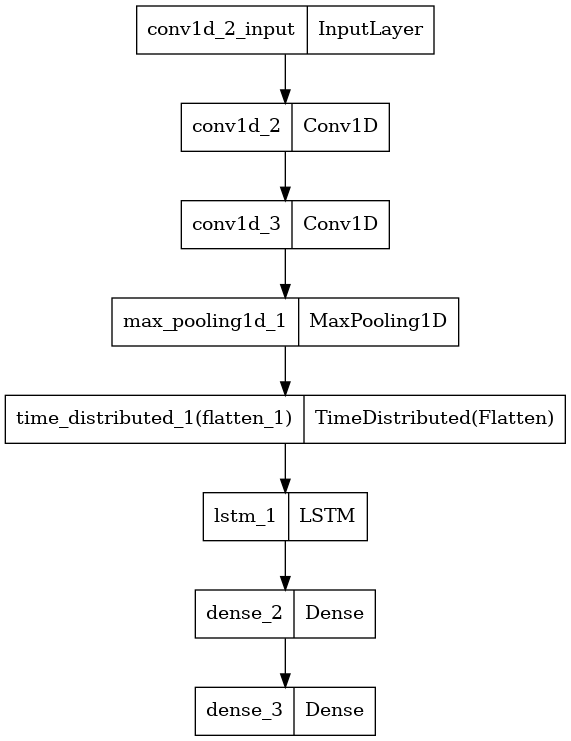

In [110]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)

In [111]:
# # Fit the model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

history = model.fit(trainX, trainY, epochs=40, batch_size=128, validation_split=0.3, callbacks=[es], verbose=1)

Epoch 1/40
1667/1667 [==============================] - 266s 157ms/step - loss: 0.0428 - val_loss: 0.0782
Epoch 2/40
1667/1667 [==============================] - 257s 154ms/step - loss: 0.0015 - val_loss: 0.0385
Epoch 3/40
1667/1667 [==============================] - 260s 156ms/step - loss: 0.0137 - val_loss: 0.0307
Epoch 4/40
1667/1667 [==============================] - 258s 155ms/step - loss: 4.0118e-04 - val_loss: 0.0291
Epoch 5/40
1667/1667 [==============================] - 260s 156ms/step - loss: 0.0010 - val_loss: 0.0165
Epoch 6/40
1667/1667 [==============================] - 260s 156ms/step - loss: 7.9619e-04 - val_loss: 0.4209
Epoch 7/40
1667/1667 [==============================] - 249s 150ms/step - loss: 5.2456e-04 - val_loss: 0.0121
Epoch 8/40
1667/1667 [==============================] - 255s 153ms/step - loss: 5.3540e-04 - val_loss: 0.0873
Epoch 9/40
1667/1667 [==============================] - 257s 154ms/step - loss: 0.0015 - val_loss: 0.0081
Epoch 10/40
1667/1667 [=======

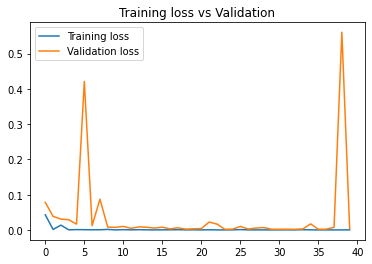

In [112]:
plot2 = plt.figure(1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title("Training loss vs Validation")
plt.legend()
plt.show()

## Setup Testing Data

In [113]:
# Import data for testing 

test_data = pd.read_csv("/home/deepfintech/Codes/Model/Crypto/ETHUSDT/ETHUSDT_Mar.csv")

test_data.head()

,open_time,open,high,low,close,volume,asset_volume,number_of_trades,taker_buy_base,taker_buy_quote
0,2022-03-01 00:00:00,2920.83,2922.99,2920.54,2921.50,474.2360,1.385585e+06,883,157.6385,4.605934e+05
1,2022-03-01 00:01:00,2921.51,2928.68,2920.65,2928.11,723.8268,2.116676e+06,1282,342.1452,1.000425e+06
2,2022-03-01 00:02:00,2928.11,2948.32,2928.10,2947.36,3322.5966,9.768564e+06,4525,1498.3316,4.406059e+06
3,2022-03-01 00:03:00,2947.36,2950.00,2938.59,2938.60,2714.5264,7.996624e+06,4298,1495.6236,4.405987e+06
4,2022-03-01 00:04:00,2938.59,2954.00,2938.39,2952.37,2235.6485,6.592711e+06,3716,1741.4753,5.135995e+06


In [114]:
#Convert 'open_time' to data type of date_time

test_data['open_time'] = pd.to_datetime(test_data['open_time'])

test_open_times = test_data['open_time']

test_data_copy = test_data.copy()
test_open_times.shape

(43201,)

In [115]:
# Get only "open","high","low","close","volume" columns.

columns = ["open","high","low","close","volume"]
test_data = test_data[columns]
test_data.head()

,open,high,low,close,volume
0,2920.83,2922.99,2920.54,2921.50,474.2360
1,2921.51,2928.68,2920.65,2928.11,723.8268
2,2928.11,2948.32,2928.10,2947.36,3322.5966
3,2947.36,2950.00,2938.59,2938.60,2714.5264
4,2938.59,2954.00,2938.39,2952.37,2235.6485


In [116]:
test_data['open_time'] = test_data_copy['open_time'].apply(lambda x: x.weekday()*24*60+x.hour*60+x.minute)

In [117]:
high_idx = argrelextrema(test_data['high'].values, np.greater, order=2)[0]
low_idx = argrelextrema(test_data['low'].values, np.less, order=2)[0]

close_high_idx = argrelextrema(test_data['close'].values, np.greater, order=2)[0]
close_low_idx = argrelextrema(test_data['close'].values, np.less, order=2)[0]

high_low_idx = np.sort(np.concatenate((close_high_idx, close_low_idx), axis=0), axis=0)

In [118]:
test_data["approx"] = np.nan
test_data["app_highs"] = np.nan
test_data["app_lows"] = np.nan

test_data

,open,high,low,close,volume,open_time,approx,app_highs,app_lows
0,2920.83,2922.99,2920.54,2921.50,474.2360,1440,NaN,NaN,NaN
1,2921.51,2928.68,2920.65,2928.11,723.8268,1441,NaN,NaN,NaN
2,2928.11,2948.32,2928.10,2947.36,3322.5966,1442,NaN,NaN,NaN
3,2947.36,2950.00,2938.59,2938.60,2714.5264,1443,NaN,NaN,NaN
4,2938.59,2954.00,2938.39,2952.37,2235.6485,1444,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
43196,3384.26,3384.26,3380.13,3380.91,153.6918,4316,NaN,NaN,NaN
43197,3380.90,3380.91,3378.24,3380.23,147.1007,4317,NaN,NaN,NaN
43198,3380.22,3380.23,3377.00,3379.40,181.6620,4318,NaN,NaN,NaN
43199,3379.40,3385.80,3379.39,3385.79,350.6894,4319,NaN,NaN,NaN


In [119]:
test_data["approx"].iloc[high_low_idx] = test_data['close'].iloc[high_low_idx]
test_data["app_highs"].iloc[high_idx] = test_data['high'].iloc[high_idx]
test_data["app_lows"].iloc[low_idx] = test_data['close'].iloc[low_idx]

/home/deepfintech/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [120]:
test_data = test_data.interpolate(method='piecewise_polynomial')

In [121]:
test_data["approx"].iloc[0] = test_data['close'].iloc[0]
test_data["approx"].iloc[-1] = test_data['close'].iloc[-1]

test_data["app_highs"].iloc[0] = test_data['high'].iloc[0]
test_data["app_highs"].iloc[-1] = test_data['high'].iloc[-1]

test_data["app_lows"].iloc[0] = test_data['close'].iloc[0]
test_data["app_lows"].iloc[-1] = test_data['close'].iloc[-1]

In [122]:
test_data = test_data.interpolate(method='piecewise_polynomial')

In [123]:
test_data

,open,high,low,close,volume,open_time,approx,app_highs,app_lows
0,2920.83,2922.99,2920.54,2921.50,474.2360,1440,2921.5000,2922.9900,2921.500000
1,2921.51,2928.68,2920.65,2928.11,723.8268,1441,2929.2175,2930.7425,2924.378571
2,2928.11,2948.32,2928.10,2947.36,3322.5966,1442,2936.9350,2938.4950,2927.257143
3,2947.36,2950.00,2938.59,2938.60,2714.5264,1443,2944.6525,2946.2475,2930.135714
4,2938.59,2954.00,2938.39,2952.37,2235.6485,1444,2952.3700,2954.0000,2933.014286
...,...,...,...,...,...,...,...,...,...
43196,3384.26,3384.26,3380.13,3380.91,153.6918,4316,3382.7200,3387.4080,3380.963333
43197,3380.90,3380.91,3378.24,3380.23,147.1007,4317,3381.0600,3387.0060,3380.181667
43198,3380.22,3380.23,3377.00,3379.40,181.6620,4318,3379.4000,3386.6040,3379.400000
43199,3379.40,3385.80,3379.39,3385.79,350.6894,4319,3385.7900,3386.2020,3380.045000


<hr style="border:2px solid gray"> </hr>

### **ABCD pattern for testing**

In [124]:
test_global_min_list, test_global_max_list, test_global_min_max_list = getABCD(test_data)

<ipython-input-125-b611c58f845a>:10: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(test_data_copy.iloc[test_global_min_max_list].open_time, test_data.iloc[test_global_min_max_list]['close'],color=colors[3], lineStyle='--')


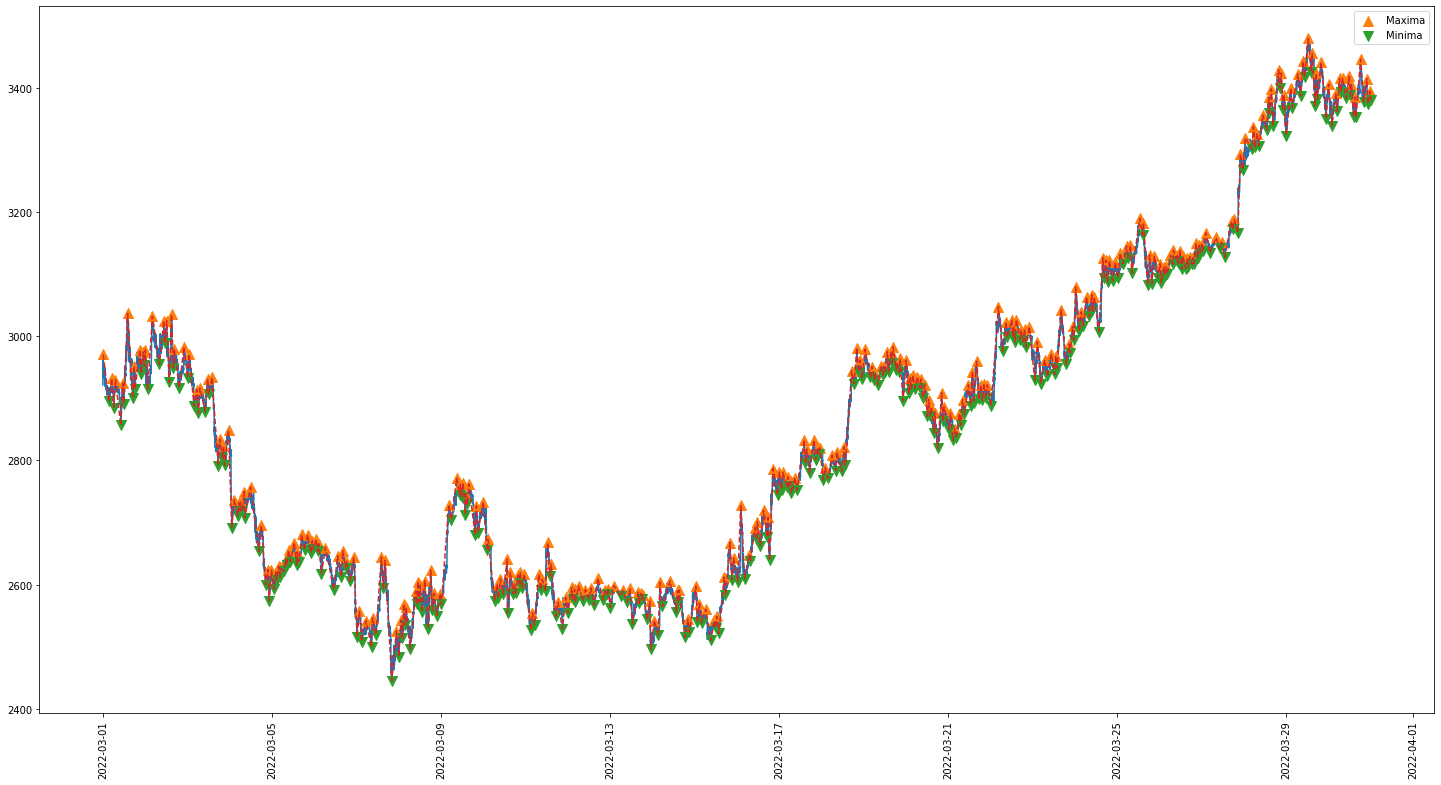

In [125]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


plt.figure(figsize=(25, 13))
plt.plot(test_data_copy.open_time , test_data['close'], zorder=0)
plt.scatter(test_data_copy.iloc[test_global_max_list].open_time, test_data.iloc[test_global_max_list]['close'],
  label='Maxima', s=100, color=colors[1], marker='^')
plt.scatter(test_data_copy.iloc[test_global_min_list].open_time, test_data.iloc[test_global_min_list]['close'],
  label='Minima', s=100, color=colors[2], marker='v')
plt.plot(test_data_copy.iloc[test_global_min_max_list].open_time, test_data.iloc[test_global_min_max_list]['close'],color=colors[3], lineStyle='--')
plt.legend()
plt.xticks(rotation = 90)
plt.show()

In [126]:
test_data['trend'] = np.nan
test_data

,open,high,low,close,volume,open_time,approx,app_highs,app_lows,trend
0,2920.83,2922.99,2920.54,2921.50,474.2360,1440,2921.5000,2922.9900,2921.500000,NaN
1,2921.51,2928.68,2920.65,2928.11,723.8268,1441,2929.2175,2930.7425,2924.378571,NaN
2,2928.11,2948.32,2928.10,2947.36,3322.5966,1442,2936.9350,2938.4950,2927.257143,NaN
3,2947.36,2950.00,2938.59,2938.60,2714.5264,1443,2944.6525,2946.2475,2930.135714,NaN
4,2938.59,2954.00,2938.39,2952.37,2235.6485,1444,2952.3700,2954.0000,2933.014286,NaN
...,...,...,...,...,...,...,...,...,...,...
43196,3384.26,3384.26,3380.13,3380.91,153.6918,4316,3382.7200,3387.4080,3380.963333,NaN
43197,3380.90,3380.91,3378.24,3380.23,147.1007,4317,3381.0600,3387.0060,3380.181667,NaN
43198,3380.22,3380.23,3377.00,3379.40,181.6620,4318,3379.4000,3386.6040,3379.400000,NaN
43199,3379.40,3385.80,3379.39,3385.79,350.6894,4319,3385.7900,3386.2020,3380.045000,NaN


In [127]:
for count in range (len(test_global_min_max_list)-1):
    if test_global_min_max_list[count] in test_global_max_list:
        for i in range(test_global_min_max_list[count], test_global_min_max_list[count+1]):
#             print (i)
#             train_data['trend'][i] = "DOWN"
            test_data['trend'][i] = -1
    
    else:
        for i in range(test_global_min_max_list[count], test_global_min_max_list[count+1]):
#             print ("UP")
            test_data['trend'][i] = 1

<ipython-input-127-997ca03a49b6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['trend'][i] = -1
<ipython-input-127-997ca03a49b6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['trend'][i] = 1


In [128]:
test_data

,open,high,low,close,volume,open_time,approx,app_highs,app_lows,trend
0,2920.83,2922.99,2920.54,2921.50,474.2360,1440,2921.5000,2922.9900,2921.500000,NaN
1,2921.51,2928.68,2920.65,2928.11,723.8268,1441,2929.2175,2930.7425,2924.378571,NaN
2,2928.11,2948.32,2928.10,2947.36,3322.5966,1442,2936.9350,2938.4950,2927.257143,NaN
3,2947.36,2950.00,2938.59,2938.60,2714.5264,1443,2944.6525,2946.2475,2930.135714,NaN
4,2938.59,2954.00,2938.39,2952.37,2235.6485,1444,2952.3700,2954.0000,2933.014286,NaN
...,...,...,...,...,...,...,...,...,...,...
43196,3384.26,3384.26,3380.13,3380.91,153.6918,4316,3382.7200,3387.4080,3380.963333,-1.0
43197,3380.90,3380.91,3378.24,3380.23,147.1007,4317,3381.0600,3387.0060,3380.181667,-1.0
43198,3380.22,3380.23,3377.00,3379.40,181.6620,4318,3379.4000,3386.6040,3379.400000,NaN
43199,3379.40,3385.80,3379.39,3385.79,350.6894,4319,3385.7900,3386.2020,3380.045000,NaN


In [129]:
test_data['trend'] = test_data['trend'].interpolate(method='nearest').ffill().bfill()

test_data

,open,high,low,close,volume,open_time,approx,app_highs,app_lows,trend
0,2920.83,2922.99,2920.54,2921.50,474.2360,1440,2921.5000,2922.9900,2921.500000,-1.0
1,2921.51,2928.68,2920.65,2928.11,723.8268,1441,2929.2175,2930.7425,2924.378571,-1.0
2,2928.11,2948.32,2928.10,2947.36,3322.5966,1442,2936.9350,2938.4950,2927.257143,-1.0
3,2947.36,2950.00,2938.59,2938.60,2714.5264,1443,2944.6525,2946.2475,2930.135714,-1.0
4,2938.59,2954.00,2938.39,2952.37,2235.6485,1444,2952.3700,2954.0000,2933.014286,-1.0
...,...,...,...,...,...,...,...,...,...,...
43196,3384.26,3384.26,3380.13,3380.91,153.6918,4316,3382.7200,3387.4080,3380.963333,-1.0
43197,3380.90,3380.91,3378.24,3380.23,147.1007,4317,3381.0600,3387.0060,3380.181667,-1.0
43198,3380.22,3380.23,3377.00,3379.40,181.6620,4318,3379.4000,3386.6040,3379.400000,-1.0
43199,3379.40,3385.80,3379.39,3385.79,350.6894,4319,3385.7900,3386.2020,3380.045000,-1.0


In [130]:
test_data.trend.value_counts()

-1.0    21954
 1.0    21247
Name: trend, dtype: int64

In [131]:
train_data.isna().sum()

open             0
high             0
low              0
close            0
volume           0
open_time        0
approx           0
app_highs        0
app_lows         0
trend            0
Hull_MA          0
ma5              0
ma8              0
ma13             0
rsi              0
macd             0
macd_signal      0
macd_hist        0
bbands_upper     0
bbands_middle    0
bbands_lower     0
obv              0
wma              0
dema             0
tema             0
adx              0
mfi              0
ppo              0
trix             0
willr            0
ultosc           0
adosc            0
ema              0
roc              0
cci              0
atr              0
ad               0
dtype: int64

<hr style="border:2px solid gray"> </hr>

### **Hull Moving Average for testing**

In [132]:
def getHullMA(df):
    df_to_hull_MA = df[['open' , 'high' , 'low' , 'close']]
    df_to_hull_MA_array = df_to_hull_MA.to_numpy()

    import numpy as np
    def lwma(Data, lookback):

        weighted = []    
        for i in range(len(Data)):
                try:
                    total = np.arange(1, lookback + 1, 1)

                    matrix = Data[i - lookback + 1: i + 1, 3:4]
                    matrix = np.ndarray.flatten(matrix)
                    matrix = total * matrix
                    wma = (matrix.sum()) / (total.sum())
                    weighted = np.append(weighted, wma)   

                except ValueError:
                    pass

        Data = Data[lookback - 1:, ]
        weighted = np.reshape(weighted, (-1, 1)) 
        Data = np.concatenate((Data, weighted), axis = 1)   

        return Data
    # For this function to work, you need to have an OHLC array composed of the four usual columns, then you can use the below syntax to get a data array with the weighted moving average using the lookback you need
    Hull_MA = pd.DataFrame(lwma(df_to_hull_MA_array, 20))[4]
    df["Hull_MA"] = Hull_MA
    return df

test_data=getHullMA(test_data)
test_data

,open,high,low,close,volume,open_time,approx,app_highs,app_lows,trend,Hull_MA
0,2920.83,2922.99,2920.54,2921.50,474.2360,1440,2921.5000,2922.9900,2921.500000,-1.0,2948.343286
1,2921.51,2928.68,2920.65,2928.11,723.8268,1441,2929.2175,2930.7425,2924.378571,-1.0,2947.987857
2,2928.11,2948.32,2928.10,2947.36,3322.5966,1442,2936.9350,2938.4950,2927.257143,-1.0,2947.436810
3,2947.36,2950.00,2938.59,2938.60,2714.5264,1443,2944.6525,2946.2475,2930.135714,-1.0,2946.574000
4,2938.59,2954.00,2938.39,2952.37,2235.6485,1444,2952.3700,2954.0000,2933.014286,-1.0,2945.835857
...,...,...,...,...,...,...,...,...,...,...,...
43196,3384.26,3384.26,3380.13,3380.91,153.6918,4316,3382.7200,3387.4080,3380.963333,-1.0,NaN
43197,3380.90,3380.91,3378.24,3380.23,147.1007,4317,3381.0600,3387.0060,3380.181667,-1.0,NaN
43198,3380.22,3380.23,3377.00,3379.40,181.6620,4318,3379.4000,3386.6040,3379.400000,-1.0,NaN
43199,3379.40,3385.80,3379.39,3385.79,350.6894,4319,3385.7900,3386.2020,3380.045000,-1.0,NaN


<hr style="border:2px solid blue"> </hr>

# Add other Technical Indicators

In [133]:
test_data["ma5"] = calculate_ma(test_data["close"], 5) #calculate moving average 5
test_data["ma8"] = calculate_ma(test_data["close"], 8) #calculate moving average 8
test_data["ma13"] = calculate_ma(test_data["close"], 13) #calculate moving average 13
test_data["rsi"] = calculate_rsi(test_data["close"], 14)
test_data["macd"], test_data["macd_signal"], test_data["macd_hist"] = calculate_macd(test_data["close"])
test_data["bbands_upper"], test_data["bbands_middle"] , test_data["bbands_lower"] = calculate_bbands(test_data["close"], 20)
test_data["obv"] = calculate_obv(test_data["close"] , test_data["volume"])
test_data["wma"] = calculate_wma(test_data["close"])
test_data["dema"] = calculate_dema(test_data["close"])
test_data["tema"] = calculate_tema(test_data["close"])
test_data["adx"] = calculate_adx(test_data["high"], test_data["low"], test_data["close"])
test_data["mfi"] = calculate_mfi(test_data["high"], test_data["low"], test_data["close"], test_data["volume"])
test_data["ppo"] = calculate_ppo(test_data["close"])
test_data["trix"] = calculate_trix(test_data["close"])
test_data["willr"] = calculate_willr(test_data["high"], test_data["low"], test_data["close"])
test_data["ultosc"] = calculate_ultosc(test_data["high"], test_data["low"], test_data["close"])
test_data["adosc"] = calculate_adosc(test_data["high"], test_data["low"], test_data["close"], test_data["volume"])
test_data["ema"] = calculate_ema(test_data["close"])
test_data["roc"] = calculate_roc(test_data["close"])
test_data["cci"] = calculate_cci(test_data["high"], test_data["low"], test_data["close"])
test_data["atr"] = calculate_atr(test_data["high"], test_data["low"], test_data["close"])
test_data["ad"] = calculate_ad(test_data["high"], test_data["low"], test_data["close"], test_data["volume"])

0        2921.50
1        2928.11
2        2947.36
3        2938.60
4        2952.37
          ...   
43196    3380.91
43197    3380.23
43198    3379.40
43199    3385.79
43200    3380.69
Name: close, Length: 43201, dtype: float64


<hr style="border:2px solid blue"> </hr>

In [134]:
test_data = test_data.dropna()
test_data = test_data.reset_index(drop=True)
test_data

,open,high,low,close,volume,open_time,approx,app_highs,app_lows,trend,...,ppo,trix,willr,ultosc,adosc,ema,roc,cci,atr,ad
0,2948.50,2952.13,2948.25,2951.01,257.0543,1480,2949.825000,2955.482000,2946.588182,-1.0,...,0.134892,0.008510,-47.397564,50.159074,752.745762,2949.037878,0.212582,30.936248,6.403292,6425.222217
1,2951.02,2954.46,2950.77,2951.15,1040.6041,1481,2951.150000,2954.460000,2945.617273,-1.0,...,0.145682,0.008804,-46.622370,41.335083,655.468328,2949.319494,0.275225,54.588499,6.209485,5598.943080
2,2951.15,2951.71,2948.48,2948.65,330.1674,1482,2948.650000,2955.568000,2944.646364,-1.0,...,0.152676,0.008814,-60.465116,37.121790,548.218385,2949.230228,-0.045763,-3.284061,5.996665,5303.530144
3,2948.65,2951.18,2947.51,2948.82,352.0492,1483,2949.080000,2956.676000,2943.675455,-1.0,...,0.157102,0.008632,-59.523810,42.633717,449.908303,2949.175531,-0.272585,-16.672193,5.830474,5202.807620
4,2948.83,2950.07,2948.14,2949.51,212.1223,1484,2949.510000,2957.784000,2942.704545,-1.0,...,0.153866,0.008368,-55.703212,42.124519,374.859318,2949.220127,-0.216178,-21.789237,5.551869,5291.833042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43137,3389.80,3389.89,3387.13,3389.89,128.6918,4297,3391.063333,3393.886667,3389.890000,-1.0,...,0.033597,0.003394,-64.930114,63.168616,209.690999,3390.847490,-0.015042,-84.117968,2.311145,123587.950750
43138,3389.88,3389.99,3388.96,3389.47,55.8546,4298,3389.470000,3392.773333,3389.985000,-1.0,...,0.033376,0.003251,-70.266836,59.974297,207.025040,3390.663825,-0.046298,-58.981581,2.219635,123587.408472
43139,3389.47,3391.66,3389.15,3391.64,145.3733,4299,3391.640000,3391.660000,3390.080000,-1.0,...,0.035133,0.003155,-42.693774,63.657438,213.988989,3390.793981,0.079671,3.636824,2.240375,123730.465066
43140,3391.64,3391.65,3390.00,3390.98,42.5444,4300,3391.446667,3391.742222,3390.175000,-1.0,...,0.033813,0.003039,-51.080051,60.836177,217.644086,3390.818784,0.011207,1.210620,2.198205,123738.458256


<hr style="border:2px solid gray"> </hr>

In [135]:
columns_to_scale = list(test_data.columns)
columns_to_scale.remove('trend')

In [136]:
# scaling testing data

scaled_testing_data = scaler.fit_transform(test_data[columns_to_scale])
scaled_testing_data.shape

(43142, 36)

In [137]:
scaled_testing_data = np.c_[ scaled_testing_data,  test_data["trend"].to_numpy()] 
scaled_testing_data.shape

(43142, 37)

In [138]:
# Create testX, testY arrays in to test the model 

testX = []
testY = []

n_future = 1  # Number of minutes we want to predict into the future
n_past = 50 # Number of past minutes we want to use to predict the future (lookback period)

for i in range(n_past, len(scaled_testing_data) - n_future + 1):
    testX.append(scaled_testing_data[i - n_past:i, 0:scaled_testing_data.shape[1]])
    testY.append(scaled_testing_data[i + n_future - 1:i + n_future, 3])

testX, testY = np.array(testX), np.array(testY)

print('testX shape == {}.'.format(testX.shape))
print('testY shape == {}.'.format(testY.shape))

testX shape == (43092, 50, 37).
testY shape == (43092, 1).


In [139]:
scaled_prediction = model.predict(testX)
next_np_scaled = np.delete(scaled_testing_data, np.s_[36], axis=1) 
scaled_prediction_copies = np.repeat(scaled_prediction, next_np_scaled.shape[1], axis=-1)
prediction = scaler.inverse_transform(scaled_prediction_copies)[:, 3]
prediction

array([2927.9275, 2928.609 , 2928.6172, ..., 3390.627 , 3391.8877,
       3391.6577], dtype=float32)

In [140]:
pd.DataFrame(prediction) 

,0
0,2927.927490
1,2928.608887
2,2928.617188
3,2925.668701
4,2925.666504
...,...
43087,3392.112305
43088,3389.750488
43089,3390.626953
43090,3391.887695


In [141]:
# Calculate Root Mean Square Error

def calculate_rmse(prediction):
    return mean_squared_error(test_data[n_past:]["close"], prediction, squared=False)

In [142]:
# Calculate Adjusted r2 score

def calculate_adj_r2(prediction):
    r2 = r2_score(test_data[n_past:]["close"], prediction)
    adjusted_r2 = 1 - ((1-r2)*(len(prediction)-1)/(len(prediction)-scaled_testing_data.shape[1]-1))
    return adjusted_r2

In [143]:
# Calculate accuracy of prediction direction

def calculate_accuracy(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    #extract the "next minute's price" of tensor
    y_true_next = y_true[1:]
    y_pred_next = y_pred[1:]
    
    #extract the "current's price" of tensor
    y_true_now = y_true[:-1]
    y_pred_now = y_pred[:-1]
    
    #substract to get up/down movement of the two tensors
    y_true_diff = np.subtract(y_true_next, y_true_now)
    y_pred_diff = np.subtract(y_pred_next, y_pred_now)
        
    #create a standard tensor with zero value for comparison
    standard = np.zeros_like(y_pred_diff)
    
    #compare with the standard; if true, UP; else DOWN
    y_true_move = np.greater_equal(y_true_diff, standard)
    y_pred_move = np.greater_equal(y_pred_diff, standard)
    
    return accuracy_score(y_true_move, y_pred_move)

In [144]:
# Calculate Root Mean Square Error

print("Root Mean squared error: " + str(calculate_rmse(prediction)))

Root Mean squared error: 3.1168013356222675


### Calculate profit for different gamma

In [145]:
def calculate_profit(y_true, y_pred, gamma):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    profit = 0
    
    trade_count = 0
    
    for i in range(len(y_true)-1):
        if y_pred[i+1]>=(y_true[i]*(100+gamma)/100):
            trade_count = trade_count + 1
            profit = profit + (100*y_true[i+1]/y_true[i])-100
#             print(y_true[i+1]- y_true[i])
    
    if trade_count == 0:
        return (0,0,0)
    
    return profit/trade_count, profit, trade_count

In [146]:
gamma_df = pd.DataFrame(index=range(50), columns=["gamma", "roi", "proft", "trade_count"])

In [147]:
for i in range(1,51):
    gamma_df["gamma"][i-1] = round(i/10.0,1)
    gamma_df["roi"][i-1], gamma_df["proft"][i-1], gamma_df["trade_count"][i-1] = calculate_profit(test_data[n_past:]["close"], prediction, round(i/10.0,1))

In [148]:
gamma_df

,gamma,roi,proft,trade_count
0,0.1,0.02878,130.084161,4520
1,0.2,0.048659,30.509282,627
2,0.3,0.076687,9.815966,128
3,0.4,0.086899,3.38905,39
4,0.5,0.037593,0.488704,13
5,0.6,-0.014077,-0.084462,6
6,0.7,-0.101565,-0.406262,4
7,0.8,-0.246482,-0.246482,1
8,0.9,-0.246482,-0.246482,1
9,1.0,0,0,0


Text(0, 0.5, 'Profit')

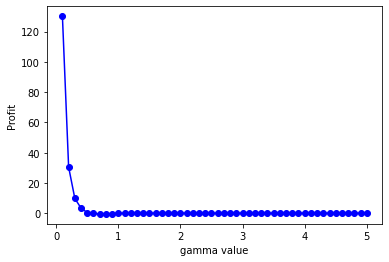

In [149]:
plot0 = plt.figure(0)
plt.plot(gamma_df["gamma"], gamma_df["proft"], "-bo")
plt.xlabel("gamma value")
plt.ylabel("Profit")

In [150]:
calculate_profit(test_data[n_past:]["close"], prediction, 0.01)

(0.011595805844287954, 270.9360035517881, 23365)

In [151]:
# Calculate Adjusted r2 score

r2 = r2_score(test_data[n_past:]["close"], prediction)
adjusted_r2 = 1 - ((1-r2)*(len(prediction)-1)/(len(prediction)-scaled_testing_data.shape[1]-1))

print("Adjusted r2 score: " + str(calculate_adj_r2(prediction)))

Adjusted r2 score: 0.9998568391373271


In [152]:
# Calculate accuracy of prediction direction

calculate_accuracy(test_data[n_past:]["close"], prediction)

0.5034229885590958

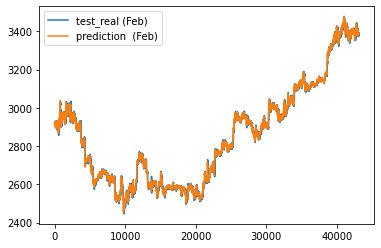

In [153]:
# Real vs Predict graph

plot2 = plt.figure(2)
plt.plot(test_data[n_past:]["close"], label="test_real (Feb)")
plt.plot(prediction, label="prediction  (Feb)")
plt.legend()
plt.show()

## For real values

In [154]:
def calculate_profit(y_true, y_pred, gamma):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    profit = 0
    
    trade_count = 0
    
    for i in range(len(y_true)-1):
        if y_true[i+1]>=(y_true[i]*(100+gamma)/100):
            trade_count = trade_count + 1
            profit = profit + (100*y_true[i+1]/y_true[i])-100
    
    if trade_count == 0:
        return (0,0,0)
    
    return profit/trade_count, profit, trade_count

In [155]:
gamma_real_df = pd.DataFrame(index=range(50), columns=["gamma", "roi", "proft", "trade_count"])

In [156]:
for i in range(1,51):
    gamma_real_df["gamma"][i-1] = round(i/10.0,1)
    gamma_real_df["roi"][i-1], gamma_real_df["proft"][i-1], gamma_real_df["trade_count"][i-1] = calculate_profit(test_data[n_past:]["close"], prediction, round(i/10.0,1))

In [157]:
gamma_real_df

,gamma,roi,proft,trade_count
0,0.1,0.168884,658.984775,3902
1,0.2,0.295504,241.131369,816
2,0.3,0.42182,110.516742,262
3,0.4,0.545372,58.354775,107
4,0.5,0.65875,32.93752,50
5,0.6,0.806406,18.547337,23
6,0.7,0.903,12.641999,14
7,0.8,1.017737,8.141898,8
8,0.9,1.122843,5.614217,5
9,1.0,1.161088,4.644353,4


In [158]:
calculate_profit(test_data[n_past:]["close"], prediction, 0.01)

(0.07043229498051569, 1325.3244946483637, 18817)